# 라이브러리 불러오기

In [380]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import seaborn as sns
import folium
import datetime

# 랜덤 시드 설정

In [9]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [10]:
_train_data = pd.read_csv('../../data/data/train.csv')
_test_data = pd.read_csv('../../data/data/test.csv')
sample_submission = pd.read_csv('../../data/data/sample_submission.csv')
subway_info = pd.read_csv('../../data/data/subwayInfo.csv')
school_info = pd.read_csv('../../data/data/schoolInfo.csv')
park_info = pd.read_csv('../../data/data/parkInfo.csv')
interest_rate = pd.read_csv('../../data/data/interestRate.csv')
_train_dist_data = pd.read_csv('../../data/data/train_dist.csv')

# 데이터 전처리하기

In [361]:
# Train
# 날짜순으로 정렬
train_data = _train_data.copy()
train_data["contract_year_month_day"] = pd.to_datetime(train_data["contract_year_month"] * 100 + train_data["contract_day"], format='%Y%m%d')
train_data = train_data.sort_values(by="contract_year_month_day")
# train_data.drop(columns=["contract_year_month", "contract_day"], inplace=True)

# 음수 age를 양수로 변환
train_data["age"] = train_data["age"].abs()

# duplicated data 제거
dup_df = train_data[train_data.drop(columns="index").duplicated()]
train_data = train_data.drop(index=dup_df.index)

train_data.shape

(1717611, 12)

In [373]:
# Test
test_data = _test_data.copy()

# 음수 age를 양수로 변환
test_data["age"] = test_data["age"].abs()

# 데이터 EDA 수행하기

In [374]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
# print("train data 상단 5개 정보 확인 : ", train_data.head())
# print("test data 상단 5개 정보 확인 : ", test_data.head())
# print("sample_submission 상단 5개 정보 확인 : ", sample_submission.head())
print("train data 변수 요약 정보 확인 : \n", train_data.describe())
print("train_dist_data 변수 요약 정보 확인 : \n", _train_dist_data.describe())
print("test data 변수 요약 정보 확인 : \n", test_data.describe())
print("subway_info 변수 요약 정보 확인 : \n", subway_info.describe())
print("school_info 변수 요약 정보 확인 : \n", school_info.describe())
print("park_info 변수 요약 정보 확인 : \n", park_info.describe())
print("interest_rate 변수 요약 정보 확인 : \n", interest_rate.describe())

train, test_data, sample_submission shape :  (1717611, 13) (150172, 10) (150172, 2)
train data 변수 요약 정보 확인 : 
               index       area_m2  contract_year_month  contract_day  \
count  1.717611e+06  1.717611e+06         1.717611e+06  1.717611e+06   
mean   9.019509e+05  7.524180e+01         2.021336e+05  1.590339e+01   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.534015e+05  5.975010e+01         2.020080e+05  9.000000e+00   
50%    9.022850e+05  7.792000e+01         2.021110e+05  1.600000e+01   
75%    1.351972e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   
std    5.193502e+05  2.558576e+01         1.353578e+02  8.629776e+00   

       contract_type         floor    built_year      latitude     longitude  \
count   1.717611e+06  1.717611e+06  1.717611e+06  1.717611e+06  1.717611e+06   
mean    1.201827e+00  1.004954e+01  2.004139e+03  3.747743e+01  1.269666e+02   


# 클러스터링

In [364]:
kmeans = KMeans(n_clusters=100)
train_data['cluster_100'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])

In [150]:
clusters = train_data[["cluster", "latitude", "longitude", "deposit"]].groupby("cluster").mean()

In [151]:
# 지도 생성 (초기 중심 좌표와 줌 레벨 설정)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=12)  # 서울 좌표 예시

# norm으로 red의 채도 변화 후 hex값으로 저장
norm = (clusters["deposit"] - clusters["deposit"].min()) / (clusters["deposit"].max() - clusters["deposit"].min())
colors = [(mcolors.to_hex([1-c, 0.5-c/2, 1])) for c in norm]

# 지도에 마커 추가 (서울 위치에 마커 추가)
for index, (lat, lon, deposit) in enumerate(zip(clusters["latitude"], clusters["longitude"], clusters["deposit"])):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,  # 원의 크기를 조정
        popup=deposit,
        color=colors[index],
        fill=True,
        fill_color=colors[index]
    ).add_to(m)
    
m

# 대회에 필요한 데이터만 활용하기

In [116]:
train_data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', 'nearest_subway_distance', 'nearest_subway_id',
       'nearest_school_distance', 'nearest_school_id', 'nearest_park_distance',
       'nearest_park_id', 'interest_rate', 'contract_year_month_day',
       'cluster'],
      dtype='object')

In [365]:
# 필요 없는 column 제거
train_df = train_data.drop(columns=["index", "contract_year_month_day"])

# contract_year_month, contract_day를 contract_year_month_day로 통합
train_df["contract_year_month_day"] = train_df["contract_year_month"] * 100 + train_df["contract_day"]
train_df.drop(columns=["contract_year_month", "contract_day"], inplace=True)

In [367]:
# cluster를 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["cluster_100"])
train_df.head()

,area_m2,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_year_month_day,cluster_100_0,...,cluster_100_90,cluster_100_91,cluster_100_92,cluster_100_93,cluster_100_94,cluster_100_95,cluster_100_96,cluster_100_97,cluster_100_98,cluster_100_99
942790,59.9100,2,12,2016,37.547574,127.012878,3,61000.0,20190401,False,...,False,False,False,False,False,False,False,False,False,False
22731,59.9940,2,23,2005,37.755550,127.075388,14,17000.0,20190401,False,...,False,False,False,False,False,False,False,False,False,False
22544,84.9454,2,9,2017,37.750609,127.103420,2,25000.0,20190401,False,...,False,False,False,False,False,False,False,False,False,False
1036408,126.6211,2,2,2018,37.480071,127.002332,1,133000.0,20190401,False,...,False,False,False,False,False,False,False,False,False,False
1036407,103.9700,2,1,1982,37.481214,127.001372,37,57000.0,20190401,False,...,False,False,False,False,False,False,False,False,False,False


# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [368]:
holdout_start = 20230701
holdout_end = 20231231
holdout_data = train_df[(train_df['contract_year_month_day'] >= holdout_start) & (train_df['contract_year_month_day'] <= holdout_end)]
train_df = train_df[~((train_df['contract_year_month_day'] >= holdout_start) & (train_df['contract_year_month_day'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [369]:
X_train = train_df.drop(columns=['deposit'])
y_train = train_df['deposit']
log_y_train = np.log1p(y_train)
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
log_y_holdout = np.log1p(y_holdout)

# LightGBM 모델 훈련

In [370]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)

# batch로 나눠서 학습
# lgb_model.fit(X_train, y_train)
batch_num = 10
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 107
[LightGBM] [Info] Start training from score 31685.657841
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 151897, number of used features: 108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG

Text(0.5, 1.0, 'Feature importance')

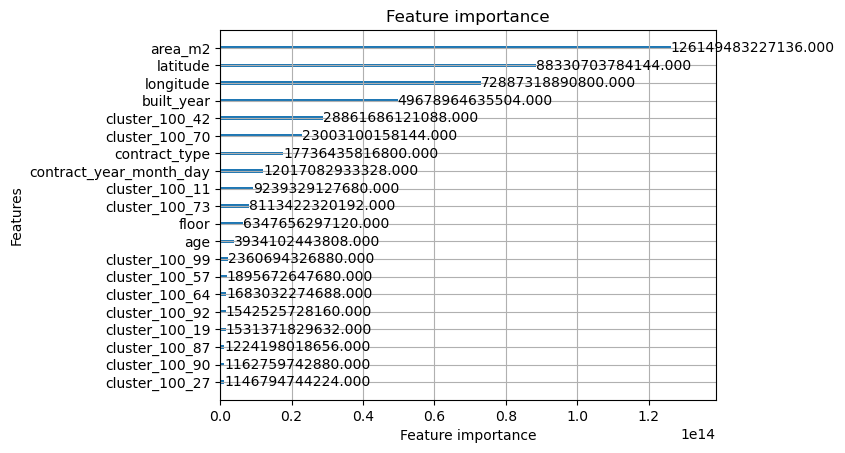

In [371]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)
plt.title('Feature importance')

# Holdout 데이터셋에 대한 성능 확인

In [372]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
# lgb_holdout_pred = np.expm1(lgb_holdout_pred_log)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 5007.98


(0.0, 40.0)

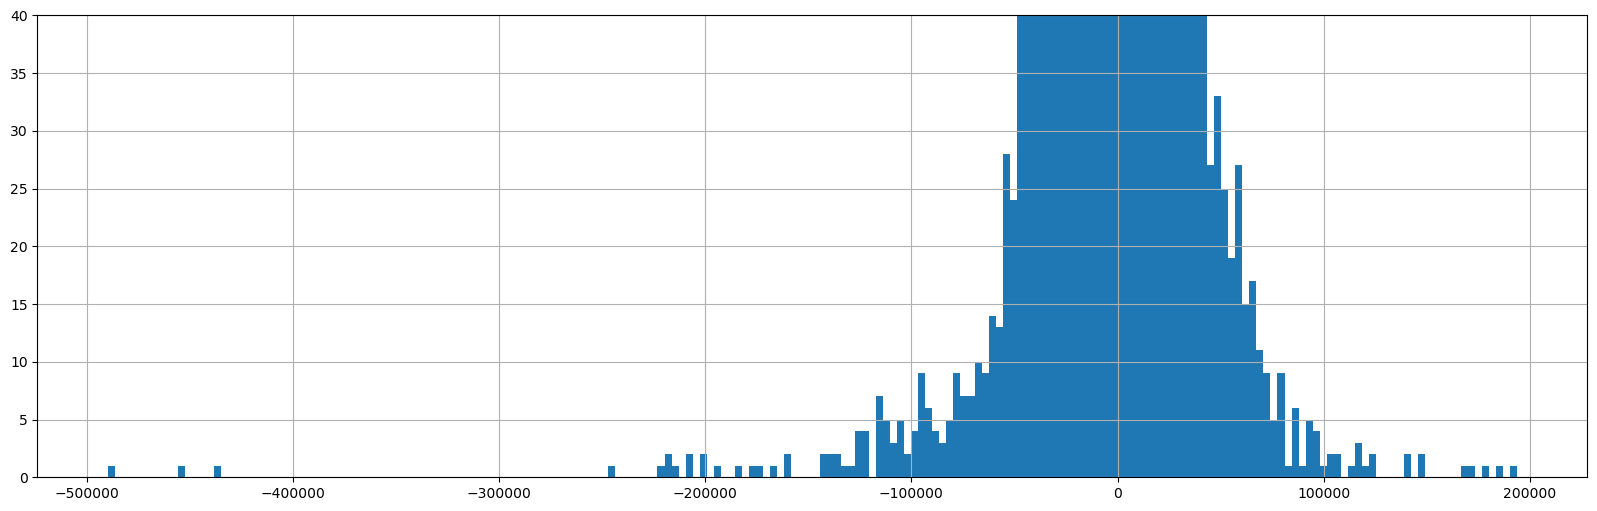

In [357]:
# target_holdout.hist(bins=50, figsize=(20, 6))
pred_df = pd.DataFrame({'pred': lgb_holdout_pred, 'target': y_holdout})
pred_df["diff"] = pred_df["pred"] - pred_df["target"]
pred_df["diff"].hist(bins=200, figsize=(20, 6))
plt.ylim(0, 40)

c:\ProgramData\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

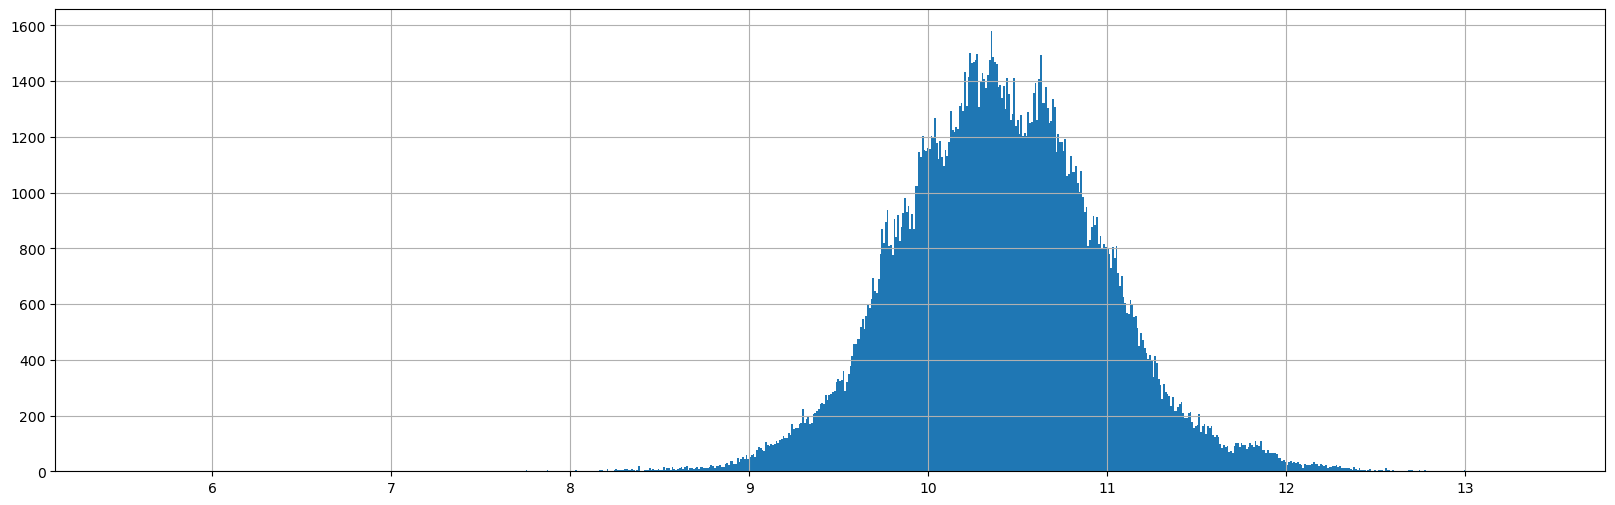

In [358]:
np.log1p(pred_df["pred"]).hist(bins=800, figsize=(20, 6))

<Axes: >

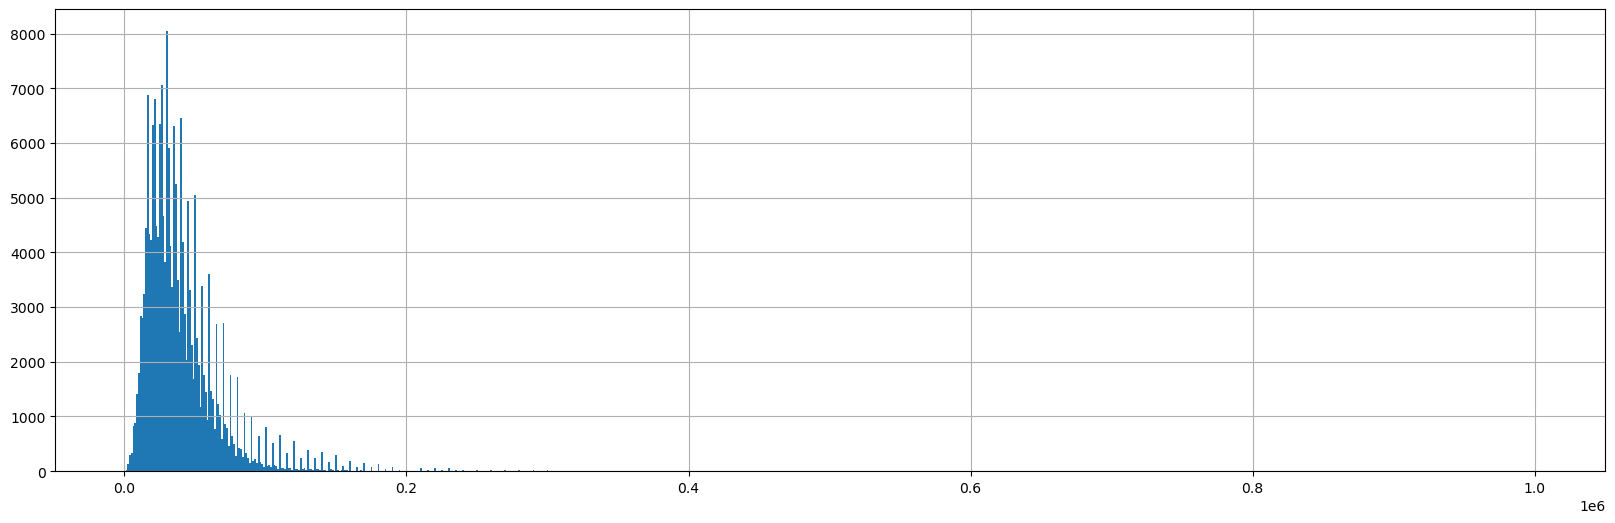

In [359]:
(pred_df["target"]).hist(bins=800, figsize=(20, 6))
# plt.xlim(10, 11)

In [360]:
pred_df.describe()

,pred,target,diff
count,198636.000000,198636.000000,198636.000000
mean,38910.125037,40903.631089,-1993.506052
std,25856.073553,28571.795590,7923.981553
min,-2734.445371,955.000000,-489839.974301
25%,22561.911921,23000.000000,-4998.656892
50%,32592.351532,34458.000000,-1407.737098
75%,47588.887221,50000.000000,1399.389986
max,652511.556205,1000000.000000,193812.972939


# Sample Submission 제출하기

In [393]:
# holdout 데이터셋도 학습에 사용
lgb_model.fit(X_holdout, y_holdout, init_model=lgb_model)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 198636, number of used features: 108


LGBMRegressor(random_state=42)

In [394]:
# 필요 없는 column 제거
test_df = test_data.drop(columns=["index"])

# contract_year_month, contract_day를 contract_year_month_day로 통합
test_df["contract_year_month_day"] = test_df["contract_year_month"] * 100 + test_df["contract_day"]
test_df.drop(columns=["contract_year_month", "contract_day"], inplace=True)

In [395]:
# cluster & one-hot encoding
test_df['cluster_100'] = kmeans.predict(test_df[['latitude', 'longitude']])
test_df = pd.get_dummies(test_df, columns=["cluster_100"])

In [396]:
lgb_test_pred = lgb_model.predict(test_df)
sample_submission['deposit'] = lgb_test_pred

In [397]:
index = datetime.datetime.now().strftime('%Y%m%d_%H%M')
sample_submission.to_csv(f'../../output/output_{index}_MAE_{lgb_holdout_mae:.2f}.csv', index=False, encoding='utf-8-sig')

# 기타: submission 분포 확인하기

In [398]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,39227.825794
std,43351.06665,24170.483963
min,0.00000,-3069.161405
25%,37542.75000,23389.171743
50%,75085.50000,33783.198336
75%,112628.25000,48837.752316
max,150171.00000,659775.635797
